In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# import missingno as msno
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# import warnings
# warnings.filterwarnings('ignore')  

# pd.set_option('display.float_format', lambda x: '%.4f' % x)

from imblearn.over_sampling import SMOTE
import itertools

In [2]:
data_cr = pd.read_csv('creditcard.csv')

In [3]:
# how imbalance the data is
data_cr.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [5]:
data_cr["Time"].tail()

284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, dtype: float64

In [6]:
data_cr['Hour'] =data_cr["Time"].apply(lambda x : divmod(x, 3600)[0])

In [11]:
data_cr['Hour'].tail()

284802    47.0
284803    47.0
284804    47.0
284805    47.0
284806    47.0
Name: Hour, dtype: float64

### hours = 47 meaning within two days transaction

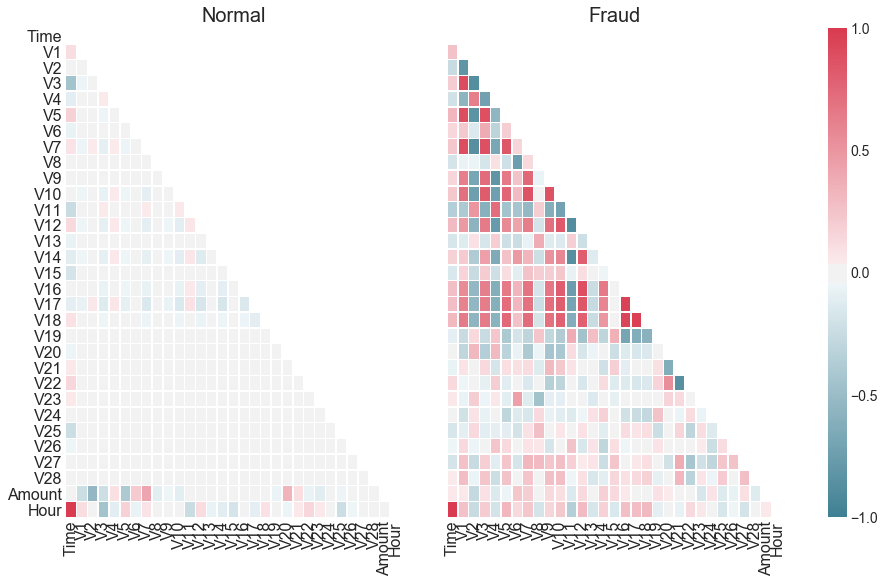

In [12]:
Xfraud = data_cr.loc[data_cr["Class"] == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = data_cr.loc[data_cr["Class"] == 0]
                  
correlationNonFraud = XnonFraud.loc[:, data_cr.columns != 'Class'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Normal', size = 20)

correlationFraud = Xfraud.loc[:, data_cr.columns != 'Class'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraud', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

## Conclusion: look at the light color box on the left, V8,V13,V15,V20,V21,V22,V23,V24,V25,V26,V27,V28, not relevent to fraud

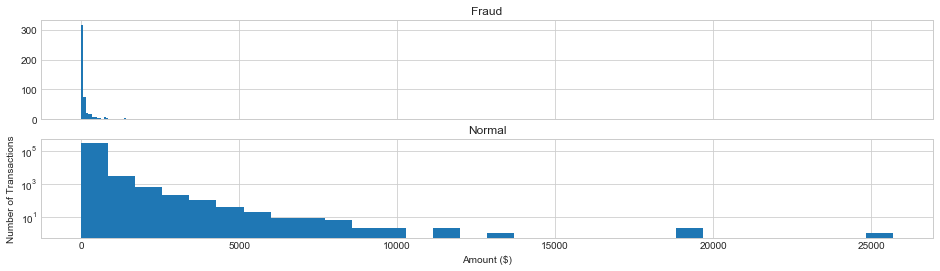

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4))

bins = 30

ax1.hist(data_cr["Amount"][data_cr["Class"]== 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data_cr["Amount"][data_cr["Class"] == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

### purchase frequency time frame 9am to 9 pm

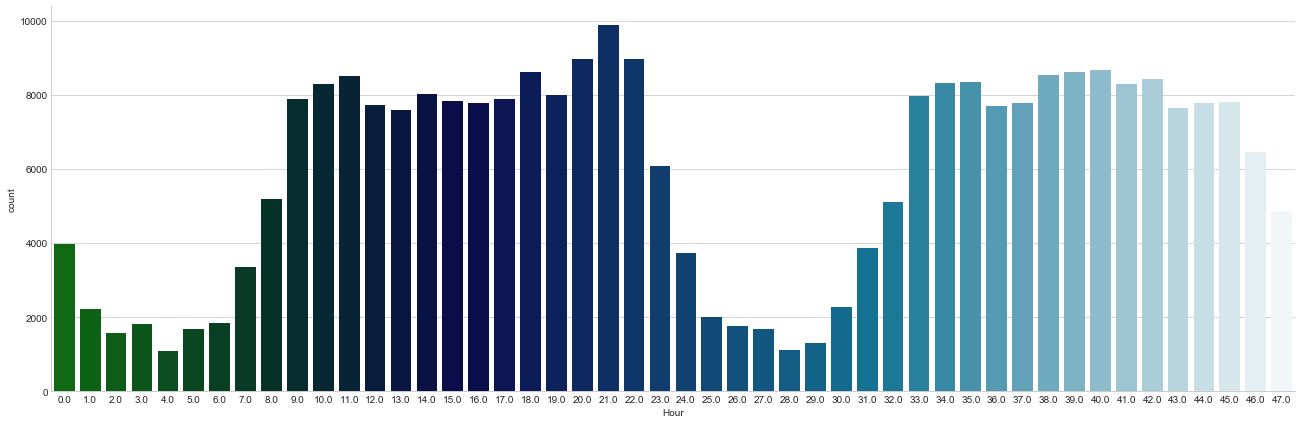

In [14]:
sns.factorplot(x="Hour", data=data_cr, kind="count",  palette="ocean", size=6, aspect=3)

In [15]:
Xfraud['Hour'] =Xfraud["Time"].apply(lambda x : divmod(x, 3600)[0])

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


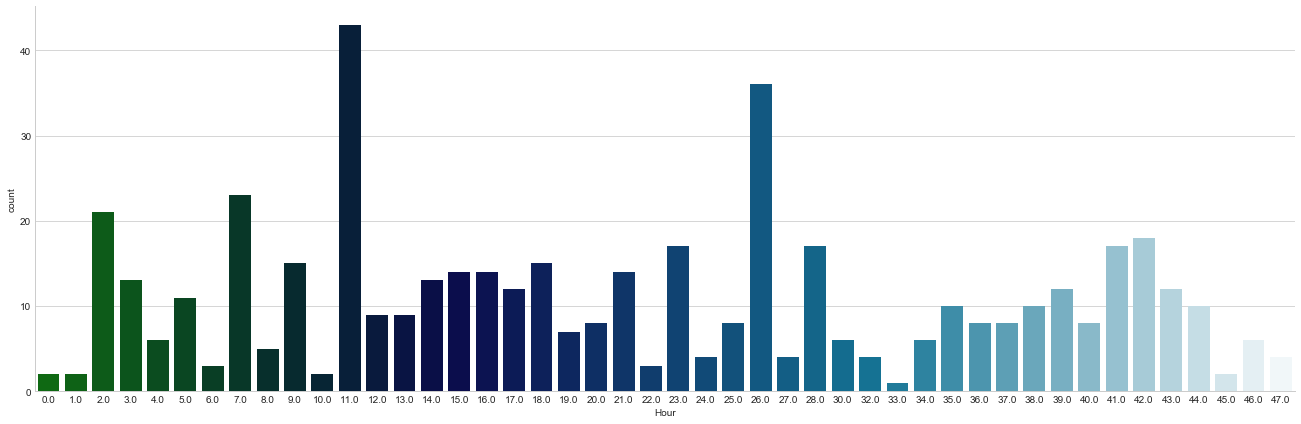

In [16]:
# Frauster pruchase time
sns.factorplot(x="Hour", data=Xfraud, kind="count",  palette="ocean", size=6, aspect=3)

### relationship between Amount and Time for Fraud and Non Fraud

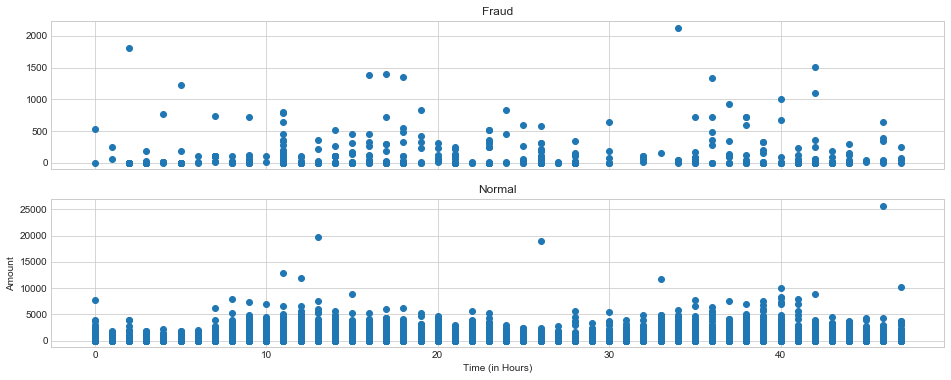

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))

ax1.scatter(data_cr["Hour"][data_cr["Class"] == 1], data_cr["Amount"][data_cr["Class"]  == 1])
ax1.set_title('Fraud')

ax2.scatter(data_cr["Hour"][data_cr["Class"] == 0], data_cr["Amount"][data_cr["Class"] == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Hours)')
plt.ylabel('Amount')
plt.show()

In [18]:
print ("Fraud Stats Summary")
print (data_cr["Amount"][data_cr["Class"] == 1].describe())
print ()
print ("Normal Stats Summary")
print (data_cr["Amount"][data_cr["Class"]  == 0].describe())

Fraud Stats Summary
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal Stats Summary
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


## summary: fraudulent behaviour
### spending is less than 500
### 11am is a peak time, and during customer sleeping time

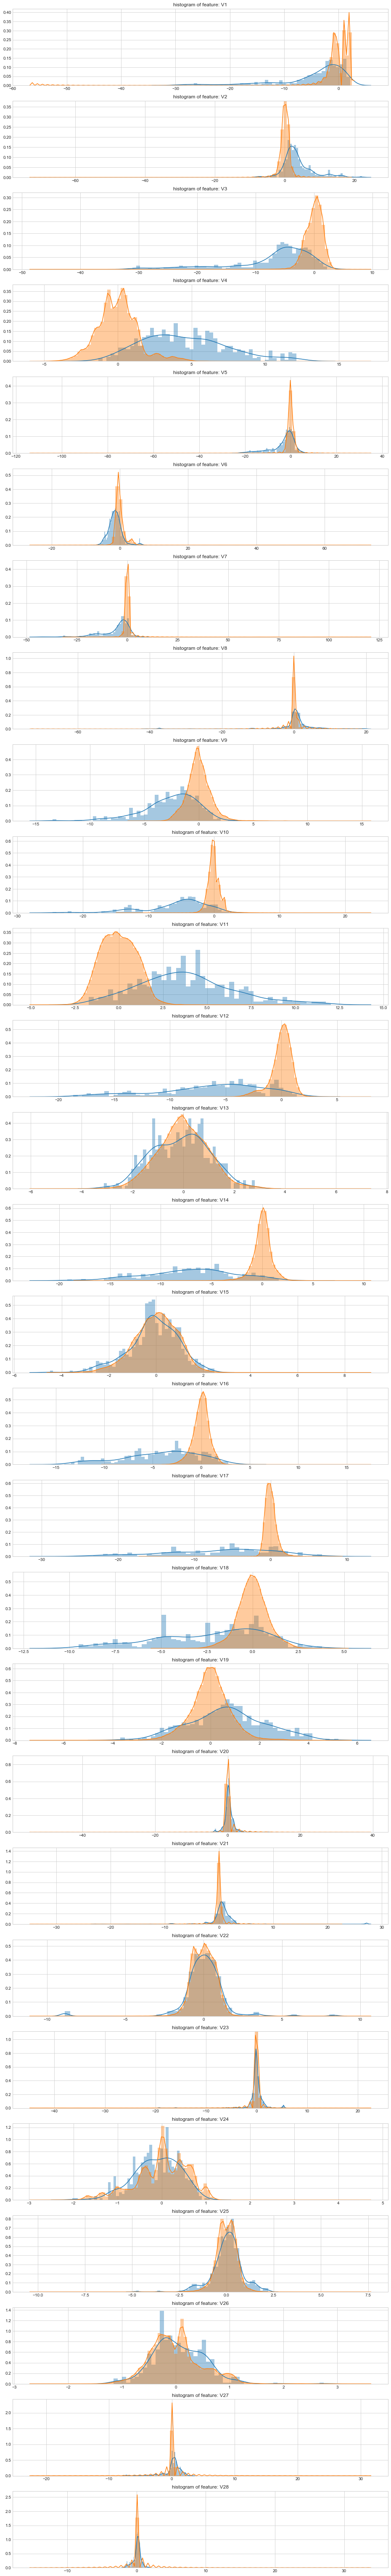

In [19]:
# plot each feature to see if it can differentiate fraud and non-fraud, V13,V15,V20,V21,V22,V23,V24,V25,V26,V27,V28 overlap
v_feat = data_cr.iloc[:,1:29].columns
plt.figure(figsize=(16,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data_cr[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(data_cr[cn][data_cr["Class"] == 1], bins=50) # in blue
    sns.distplot(data_cr[cn][data_cr["Class"] == 0], bins=100) # in orange
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))

In [20]:
# keep the hour, drop the time
droplist = ['V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Time']
data_new = data_cr.drop(droplist, axis = 1)
data_new.shape

(284807, 19)

In [21]:
col = ['Amount','Hour']
from sklearn.preprocessing import StandardScaler
sc =StandardScaler()
data_new[col] =sc.fit_transform(data_new[col])

In [22]:
x_feature = list(data_new.columns)
x_feature

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'Amount',
 'Class',
 'Hour']

In [23]:
x_feature.remove('Class')
x_feature

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'Amount',
 'Hour']

In [24]:
x_val = data_new[x_feature]
x_val.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.244964,-1.960264
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.342475,-1.960264
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,1.160686,-1.960264
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,0.140534,-1.960264
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.073403,-1.960264


In [25]:
y_val = data_new['Class']

## feature importance

In [26]:
names = data_cr[x_feature].columns
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=10,random_state=123)
clf.fit(x_val, y_val)
names, clf.feature_importances_
for feature in zip(names, clf.feature_importances_):
    print(feature)

('V1', 0.016428960714380998)
('V2', 0.012088954341890348)
('V3', 0.019333047192017873)
('V4', 0.0419543803589887)
('V5', 0.01812418059009202)
('V6', 0.02126325840563289)
('V7', 0.02330647145553924)
('V9', 0.022616308229698158)
('V10', 0.08104934217396946)
('V11', 0.06706027490232476)
('V12', 0.1319622660254698)
('V14', 0.12929955280214372)
('V16', 0.14082738583269536)
('V17', 0.211273164259213)
('V18', 0.01952899409481077)
('V19', 0.02003014913528499)
('Amount', 0.011748452413655337)
('Hour', 0.012104857072192587)


In [34]:
feature_importances = pd.Series(clf.feature_importances_)
names_df = pd.DataFrame(names)
names_df['feature_importances'] = feature_importances
names_df.sort_values('feature_importances', ascending = False)

,0,feature_importances
13,V17,0.211273
12,V16,0.140827
10,V12,0.131962
11,V14,0.129300
8,V10,0.081049
9,V11,0.067060
3,V4,0.041954
6,V7,0.023306
7,V9,0.022616
5,V6,0.021263


(-1, 18)

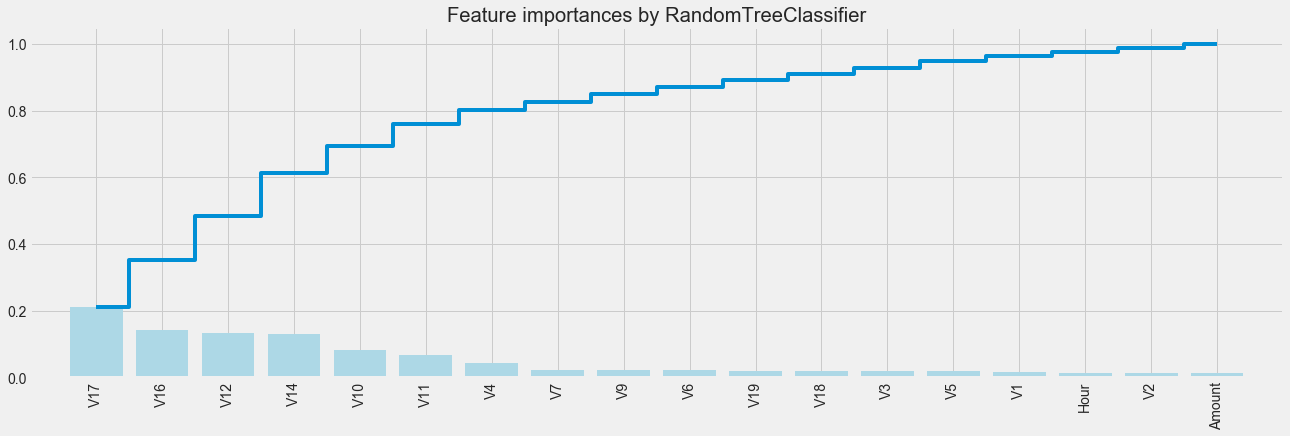

In [19]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)
importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

### SMOTE resampling

In [36]:
X = data_cr[x_feature]
y = data_cr["Class"]

n_sample = y.shape[0]
n_sample

284807

In [38]:
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('sample size：{}; pos_sample {:.2%}; neg_sample {:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('feature dimension：', X.shape[1])

sample size：284807; pos_sample 99.83%; neg_sample 0.17%
feature dimension： 18


In [39]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_sample(X, y)
print('after SMOTE')
n_sample = y.shape[0]
n_sample

after SMOTE


568630

In [43]:
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
n_pos_sample  

284315

In [44]:
n_neg_sample

284315

In [45]:
print('sample size：{}; pos_sample_percent {:.2%}; neg_sample_percent {:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample)) 

sample size：568630; pos_sample_percent 50.00%; neg_sample_percent 50.00%


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],'penalty': [ 'l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=10) 
grid_search.fit(X_train, y_train) # Take 5 min

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
results = pd.DataFrame(grid_search.cv_results_) 
best = np.argmax(results.mean_test_score.values)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'penalty': 'l1'}
Best cross-validation score: 0.95817


C:\Users\Hugo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Hugo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Hugo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Hugo\Anaconda3\lib\site-packages\sklearn\utils\depr

In [52]:
y_pred = grid_search.predict(X_test)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_test, y_pred,)))

Test set accuracy score: 0.95856


In [53]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96     85172
          1       0.98      0.93      0.96     85417

avg / total       0.96      0.96      0.96    170589



Recall metric in the testing dataset:  0.9324022150157463


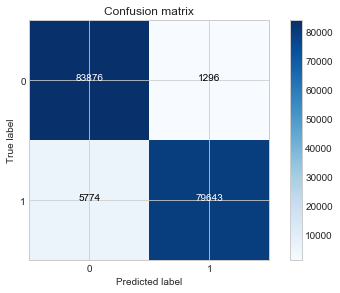

In [54]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

Threshold : 0.1
Recall :  0.9825678729058618
precision :  0.8764777141902335
accuracy :  0.9219351775319627
 
Threshold : 0.2
Recall :  0.9675006146317477
precision :  0.9323217509025271
accuracy :  0.9485605754181102
 
Threshold : 0.3
Recall :  0.9527026235995176
precision :  0.9613462651655661
accuracy :  0.9571367438697689
 
Threshold : 0.4
Recall :  0.9419202266527741
precision :  0.9752124216676161
accuracy :  0.9589305289321117
 
Threshold : 0.5
Recall :  0.9324022150157463
precision :  0.9839879415362186
accuracy :  0.9585553582001184
 
Threshold : 0.6
Recall :  0.9261856539096432
precision :  0.9882699778890957
accuracy :  0.9575353627725117
 
Threshold : 0.7
Recall :  0.9197232401044289
precision :  0.9904685057239396
accuracy :  0.955372269020863
 
Threshold : 0.8
Recall :  0.9118442464614772
precision :  0.9917994167908215
accuracy :  0.9520836630732346
 
Threshold : 0.9
Recall :  0.8993174660781812
precision :  0.9950130825626279
accuracy :  0.9473295464537572
 


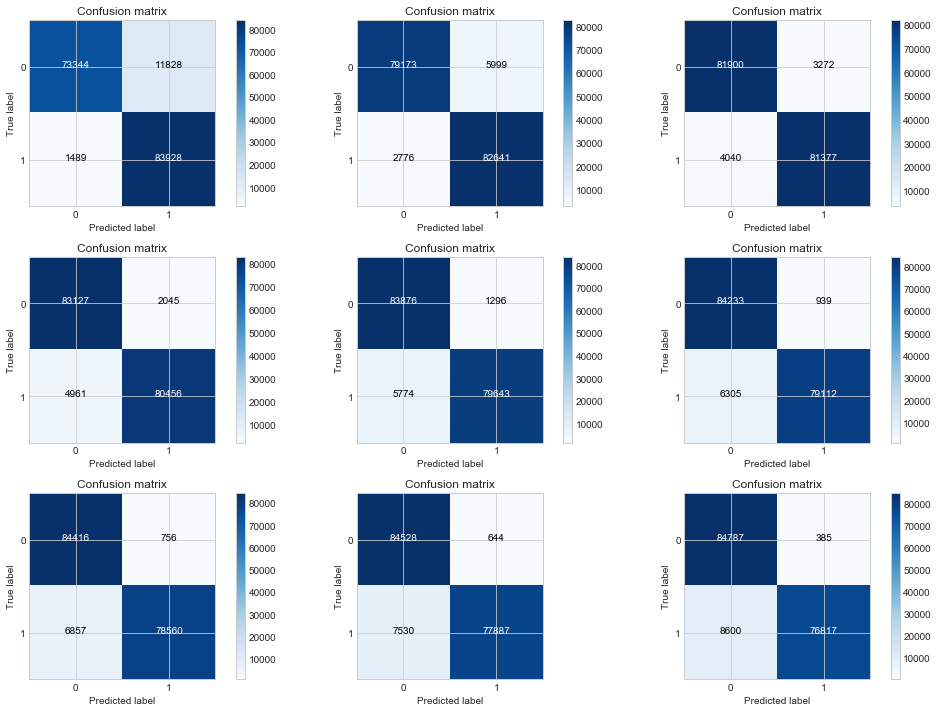

In [61]:
y_pred_proba = grid_search.predict_proba(X_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(15,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    cnf_matrix = confusion_matrix(y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Threshold :" , i)
    print("Recall : ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    print("precision : ", cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))
    print("accuracy : ", (cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[0,1]+cnf_matrix[1,0]))
    print(" ")
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix,classes=class_names, title='Confusion matrix')
plt.show()

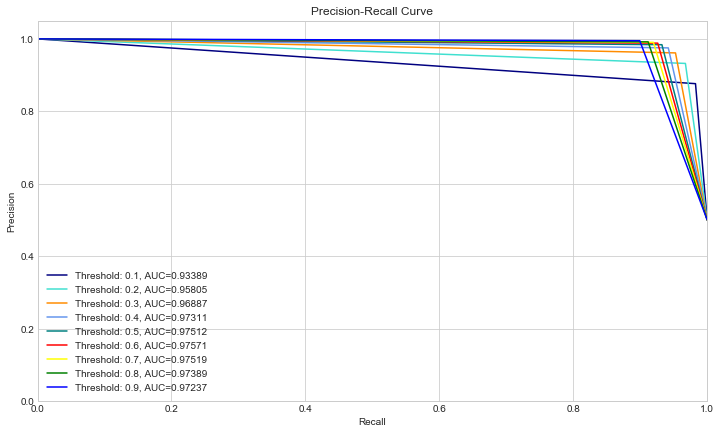

In [57]:
from itertools import cycle

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i #预测出来的概率值是否大于阈值  

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")